<a href="https://www.kaggle.com/code/egesaydin/computeraidedtermproject?scriptVersionId=182462601" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
from transformers import (
    SwinForImageClassification,
    AutoImageProcessor,
    Trainer,
    TrainingArguments,
    default_data_collator,
    ConvNextV2ForImageClassification,
    PvtV2ForImageClassification,
    MobileViTForImageClassification,
    DeiTForImageClassification,
    MobileNetV2ForImageClassification
)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

2024-06-09 21:20:49.621391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 21:20:49.621496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 21:20:49.753320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path to dataset
data_dir = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'

In [3]:
# Processing dataset
class CancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return {"pixel_values": image, "label": label}

def load_data(root_dir):
    labels_dict = {
        "Bengin cases": 0, "Malignant cases": 1, "Normal cases": 2
    }
    image_paths = []
    labels = []

    for label_folder in labels_dict.keys():
        class_folder = os.path.join(root_dir, label_folder)
        label_id = labels_dict[label_folder]
        for filename in os.listdir(class_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  
                image_paths.append(os.path.join(class_folder, filename))
                labels.append(label_id)

    return image_paths, labels

In [4]:
# Transformations for the training and validation sets 256
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
# Load data
image_paths, labels = load_data(data_dir)

# Adjust size of data
subset_size = 1  # Use 100% of the data
subset_indices = torch.randperm(len(image_paths))[:int(len(image_paths) * subset_size)]
image_paths = [image_paths[i] for i in subset_indices]
labels = [labels[i] for i in subset_indices]

# Split the data into training and validation sets
train_size = int(0.8 * len(image_paths))
val_size = len(image_paths) - train_size
train_indices, val_indices = random_split(range(len(image_paths)), [train_size, val_size])
train_image_paths = [image_paths[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_labels = [labels[i] for i in val_indices]

# Create datasets
train_dataset = CancerDataset(train_image_paths, train_labels, transform=train_transform)
val_dataset = CancerDataset(val_image_paths, val_labels, transform=val_transform)

# Use DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_data_collator)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=default_data_collator)


Original images without transformation:


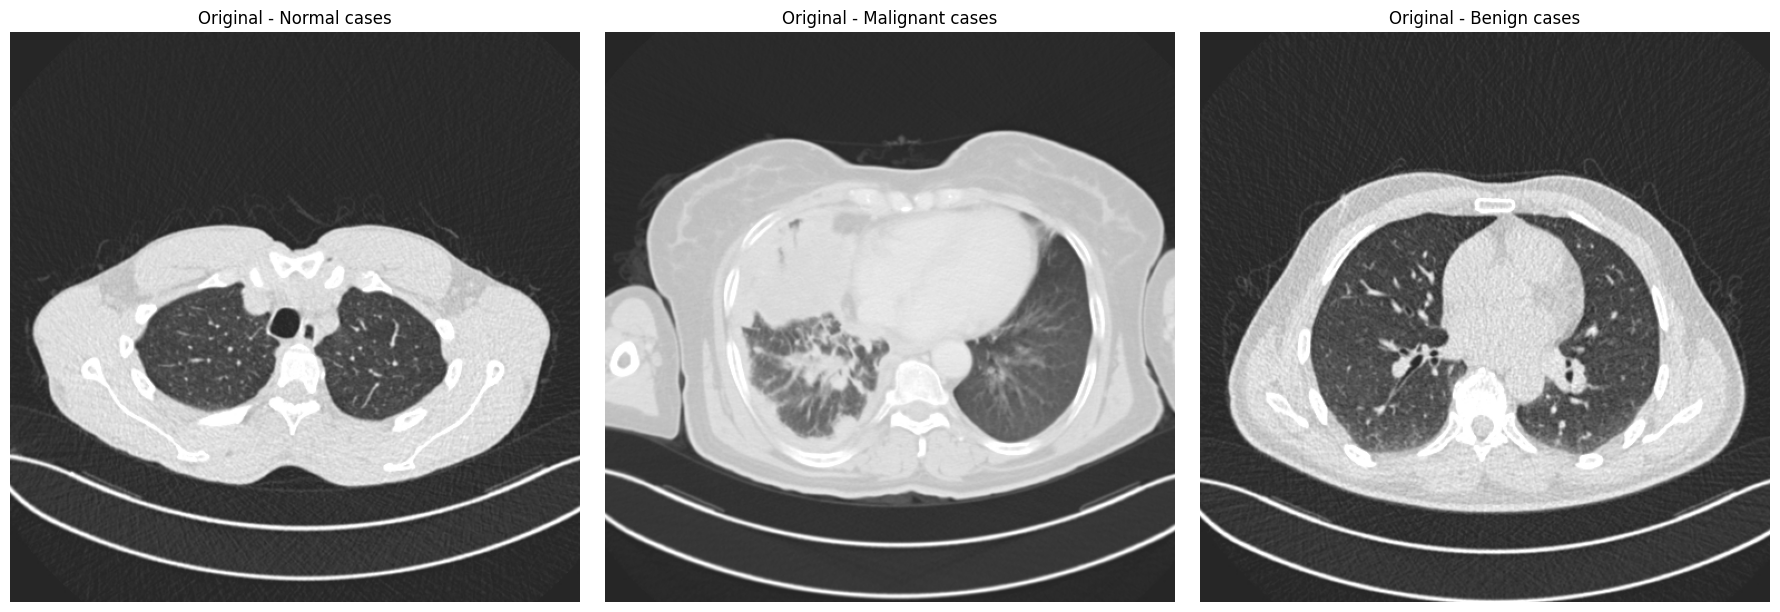

In [6]:
# Define label_to_text function
def label_to_text(label):
    labels_dict = {0: "Benign cases", 1: "Malignant cases", 2: "Normal cases"}
    return labels_dict.get(label, "Unknown label")

def show_image(image, title, ax):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

def display_original_images(image_paths, labels):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns (one for each class)

    # Select one image from each class
    selected_images = {}
    for image_path, label in zip(image_paths, labels):
        if label not in selected_images:
            selected_images[label] = image_path
        if len(selected_images) == 3:
            break

    for i, (label, image_path) in enumerate(selected_images.items()):
        image = Image.open(image_path)
        show_image(image, f"Original - {label_to_text(label)}", axes[i])

    plt.tight_layout()
    plt.show()

# Display one original image from each class
print("Original images without transformation:")
display_original_images(image_paths, labels)

Images before and after transformation:


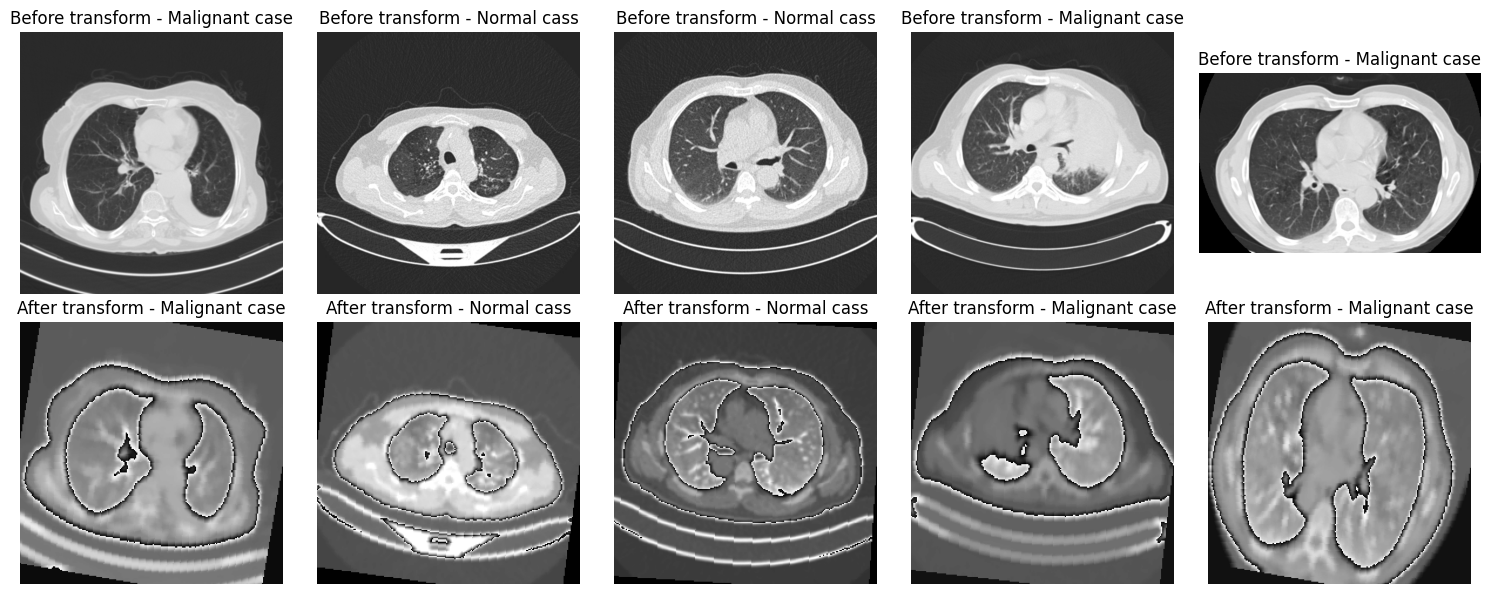

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F
import numpy as np

# Function to display images
def show_image(image, title, ax):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

# Define label_to_text function
def label_to_text(label):
    labels_dict = {0: "Benign case", 1: "Malignant case", 2: "Normal cass"}
    return labels_dict.get(label, "Unknown label")

def display_images(image_paths, labels, transform, num_images=5):
    # Select a subset of images to display
    selected_indices = np.random.choice(len(image_paths), num_images, replace=False)
    selected_image_paths = [image_paths[i] for i in selected_indices]
    selected_labels = [labels[i] for i in selected_indices]
    
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))

    for i, (image_path, label) in enumerate(zip(selected_image_paths, selected_labels)):
        image = Image.open(image_path)
        show_image(image, f"Before transform - {label_to_text(label)}", axes[0, i])
        
        # Apply transform
        transformed_image = transform(image)
        transformed_image = F.to_pil_image(transformed_image)
        show_image(transformed_image, f"After transform - {label_to_text(label)}", axes[1, i])

    plt.tight_layout()
    plt.show()

# Display some training images before and after transformation
print("Images before and after transformation:")
display_images(train_image_paths, train_labels, train_transform)

In [8]:
option = 5

if option == 1:
    model_name = "microsoft/swinv2-tiny-patch4-window8-256"
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = SwinForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
elif option == 2:
    model_name = "facebook/convnextv2-tiny-1k-224"
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = ConvNextV2ForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
elif option == 3:
    model_name = "OpenGVLab/pvt_v2_b0"
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = PvtV2ForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
elif option == 4:
    model_name = "apple/mobilevit-small"
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = MobileViTForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
elif option == 5:
    model_name = "facebook/deit-base-distilled-patch16-224"
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = DeiTForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
elif option == 6:
    model_name = "google/deeplabv3_mobilenet_v2_1.0_513"
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = MobileNetV2ForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
else:
    raise ValueError("Invalid option selected. Please choose a valid model option.")

model.to(device)


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(p.label_ids, preds)
    precision = precision_score(p.label_ids, preds, average='weighted', zero_division=0)
    recall = recall_score(p.label_ids, preds, average='weighted', zero_division=0)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    
    # Calculate AUC score
    # Assuming p.predictions are logits, apply softmax to get probabilities
    probs = torch.nn.functional.softmax(torch.tensor(p.predictions), dim=-1).numpy()
    try:
        auc = roc_auc_score(p.label_ids, probs, multi_class='ovr', average='weighted')
    except ValueError:
        auc = float('nan')  

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=100,  # Number of epochs
    per_device_train_batch_size=32,  # Batch size
    per_device_eval_batch_size=32,
    warmup_steps=500,  # Warmup steps
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3,  # Limit the number of saved models
    lr_scheduler_type='cosine_with_restarts',  
)


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Use the Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained("./trained_model")
image_processor.save_pretrained("./trained_model")


# Evaluate the model
results = trainer.evaluate()
print(results)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,1.036400,1.004875,0.445455,0.553630,0.445455,0.423878,0.627292
2,0.986900,0.879050,0.640909,0.636998,0.640909,0.622137,0.769257
3,0.850800,0.810993,0.645455,0.706545,0.645455,0.627577,0.874769
4,0.744600,0.697966,0.718182,0.771306,0.718182,0.706028,0.912544
5,0.576100,0.537668,0.854545,0.880075,0.854545,0.828263,0.941172
6,0.457900,0.462530,0.850000,0.890023,0.850000,0.825777,0.961257
7,0.409600,0.448149,0.877273,0.899154,0.877273,0.873039,0.971039
8,0.293200,0.264273,0.918182,0.914050,0.918182,0.915174,0.986099
9,0.244000,0.247782,0.909091,0.908745,0.909091,0.905438,0.985246
10,0.185100,0.212426,0.909091,0.907946,0.909091,0.908316,0.988116


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


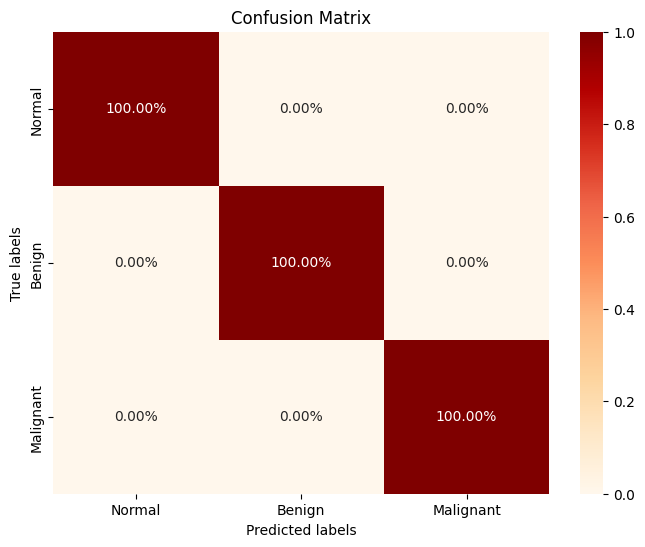

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import numpy as np

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="OrRd", xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

val_preds = trainer.predict(val_dataset)

# Extract true labels and predicted labels
y_true = [example['label'] for example in val_dataset]
y_pred = np.argmax(val_preds.predictions, axis=1)

class_names = ['Normal', 'Benign', 'Malignant']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

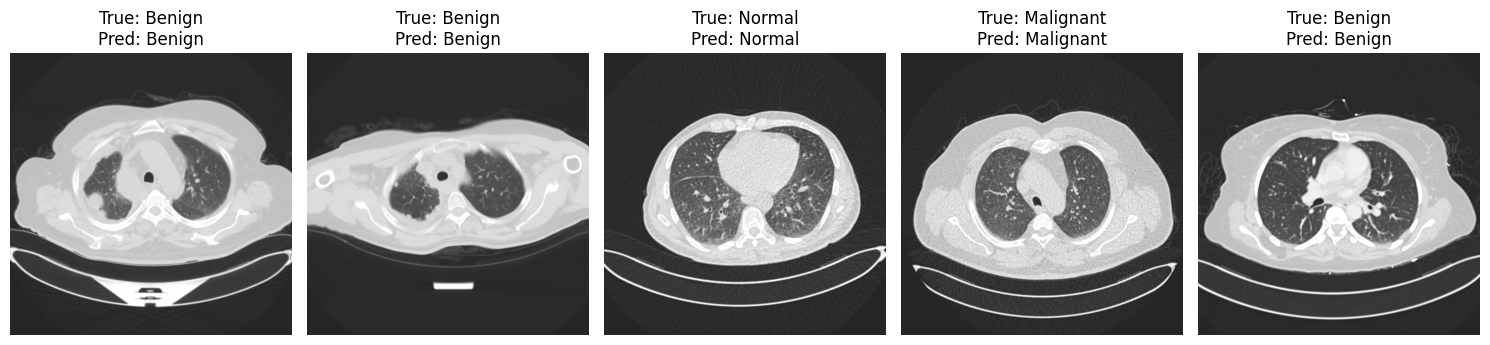

In [14]:
def visualize_ct_predictions(image_paths, y_true, y_pred, class_names, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 5))

    for i in range(num_images):
        img = Image.open(image_paths[i])
        true_label = y_true[i]
        pred_label = y_pred[i]

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_ct_predictions(val_image_paths, y_true, y_pred, class_names)


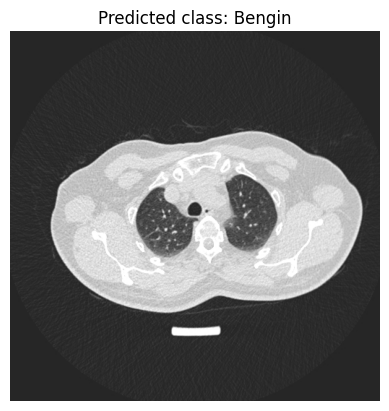

Predicted class: Bengin


In [41]:
def predict_and_show_image(image_path, model, image_processor, class_names):

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt")

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_idx]

    # Show the image with the predicted class name
    plt.imshow(image)
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.axis('off')
    plt.show()

    print(f"Predicted class: {predicted_class_name}")

# Example class names

# Load the trained model and processor
loaded_model = DeiTForImageClassification.from_pretrained("/kaggle/working/trained_model")
loaded_model.to('cuda' if torch.cuda.is_available() else 'cpu')

image_processor = AutoImageProcessor.from_pretrained("/kaggle/working/trained_model")

class_names = ['Bengin', 'Malignant', 'Normal']


# Example usage
image_path = "/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (5).jpg" 
predict_and_show_image(image_path, loaded_model, image_processor, class_names)